In [1]:
from datasets import load_dataset, Dataset, concatenate_datasets
import pandas as pd
from collections import defaultdict
import copy
import json
import re
from sklearn.metrics import ndcg_score
import math
import numpy as np
import itertools
from statistics import mean
from typing import List, Dict


# setup

In [2]:
cosqa_qce_retrieved_docs = '/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/cosqa/qce/granite1/dres/intfloat/e5-base-v2/query_corpus_expansion_results.json'
collapsed_qce = '/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/cosqa/qce/granite1/dres/intfloat/e5-base-v2/retrieval_evaluation.csv'

cosqa_qe_retrieved_docs = '/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/cosqa/qe/variants_expanded_granite/includingOg/granite1/dres/intfloat/e5-base-v2/query_corpus_expansion_results.json'
collapsed_qe = '/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/cosqa/qe/variants_expanded_granite/includingOg/granite1/dres/intfloat/e5-base-v2/retrieval_evaluation.csv'

cosqa_retrieved_docs = '/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/cosqa/dedup/granite1/dres/intfloat/e5-base-v2/retrieval_evaluation.csv'

cosqa_baseline_retrieved_docs = '/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/cosqa/dedup/baseline/dres/intfloat/e5-base-v2/retrieval_evaluation.csv'

cosqa_granite_variants_corpus_expansions = '/work/pi_wenlongzhao_umass_edu/27/anamikaghosh/CS696DS-Oracle-Retrieving-Code-Explanations/Explanation_Generation/Cosqa/postprocessing/output/COSQA_granite_explanations_clean_new_prompts.csv'
cosqa_data_path='/work/pi_wenlongzhao_umass_edu/27/anamikaghosh/CS696DS-Oracle-Retrieving-Code-Explanations/Explanation_Generation/Cosqa/postprocessing/output/COSQA_granite_explanations_clean.csv'
cosqa_queries_variants_expanded_granite='/work/pi_wenlongzhao_umass_edu/27/janet/query_expansion/results/cosqa/variants_based_prompting/cosqa_queries_variants_expanded_granite.csv'


In [3]:
df = pd.read_csv(cosqa_data_path)
df = df[['query_id', 'corpus_id', 'doc', 'code','explanation_granite_1_cleaned']]
df.rename(columns={'explanation_granite_1_cleaned':'explanation_granite_0_cleaned'}, inplace=True)
df_expanded_corpus = pd.read_csv(cosqa_granite_variants_corpus_expansions)
df_expanded_corpus = df_expanded_corpus[['corpus_id','explanation_granite_1_cleaned',
       'explanation_granite_2_cleaned', 'explanation_granite_3_cleaned',
       'explanation_granite_4_cleaned', 'explanation_granite_5_cleaned']]
df_merged = pd.merge(df_expanded_corpus, df[['corpus_id', 'explanation_granite_0_cleaned']], on='corpus_id', how='left')
df_merged.rename(columns={'explanation_granite_0_cleaned':'original', 'explanation_granite_1_cleaned': 'user_intent', 'explanation_granite_2_cleaned': 'technical', 'explanation_granite_3_cleaned':'generic', 'explanation_granite_4_cleaned': 'semi_technical','explanation_granite_5_cleaned':'high_level'}, inplace=True)
df_query = pd.read_csv(cosqa_queries_variants_expanded_granite)
df_query = df_query.pivot(index=['id', 'original_query'], columns='Prompt_type', values='generated_explanation')
df_query = df_query.reset_index()
df_query = df_query[['id','original_query','general',
       'high_level', 'semi-technical',
       'technical', 'user_intent']]
df_query.rename(columns={'id':'query_id','semi-technical':'semi_technical','original_query':'original', 'general':'generic'}, inplace=True)
df_query.columns.name = None
qrels = df[['query_id', 'corpus_id']]
qrels['relevance'] = 1
corpus_exp_df = df_merged[['corpus_id','original', 'user_intent',
       'generic', 'technical', 'semi_technical', 'high_level']]
query_exp_df = df_query

/tmp/ipykernel_1787165/1326945997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qrels['relevance'] = 1


In [4]:
qrels.head()

,query_id,corpus_id,relevance
0,q1,d1,1
1,q2,d2,1
2,q3,d3,1
3,q4,d4,1
4,q5,d5,1


In [5]:
with open(cosqa_qe_retrieved_docs) as f:
    qe_results = json.load(f) 

with open(cosqa_qce_retrieved_docs) as f:
    qce_results = json.load(f)

In [6]:
print(len(qce_results)) # 500 * 6
print(len(qce_results['q20105.0']) ) # each query retrieves 1000

3000
1000


In [7]:
def split_full_id(full_id):
    """Split 'q1.2' into ('q1', '2') or 'd3.5' into ('d3', '5')."""
    base, suffix = full_id.split('.')
    return base, suffix

In [8]:
rows = []

for q_full, hits in qe_results.items():
    q_base,q_prompt = split_full_id(q_full)
    for d_base, score in hits.items():
        rows.append({
            'expansion': 'QE-only',
            'query_full': q_full, 'query_base': q_base, 'q_prompt': q_prompt,
            'doc_full': d_base,   'doc_base': d_base,   'd_prompt': '0',
            'score': score
        })

for q_full, hits in qce_results.items():
    q_base,q_prompt = split_full_id(q_full)
    for d_full, score in hits.items():
        d_base,d_prompt = split_full_id(d_full)
        rows.append({
            'expansion': 'QE+CE',
            'query_full': q_full, 'query_base': q_base, 'q_prompt': q_prompt,
            'doc_full': d_full,   'doc_base': d_base,   'd_prompt': d_prompt,
            'score': score
        })



all_df = pd.DataFrame(rows)

In [9]:
baseline_df = pd.read_csv(cosqa_baseline_retrieved_docs)
baseline_df = baseline_df.rename(columns={
    'query_id': 'query_full',
    'retrieved_doc_id': 'doc_full'
})

baseline_df['expansion'] = 'baseline'
baseline_df['query_base'] = baseline_df['query_full']
baseline_df['q_prompt'] = '0'
baseline_df['doc_base'] = baseline_df['doc_full']
baseline_df['d_prompt'] = '0'

baseline_df = baseline_df[[
    'expansion', 'query_full', 'query_base', 'q_prompt',
    'doc_full', 'doc_base', 'd_prompt', 'score'
]]
all_df = pd.concat([all_df, baseline_df], ignore_index=True)

In [10]:
expl_df = pd.read_csv(cosqa_retrieved_docs)
expl_df = expl_df.rename(columns={
    'query_id': 'query_full',
    'retrieved_doc_id': 'doc_full'
})

expl_df['expansion'] = 'none'
expl_df['query_base'] = expl_df['query_full']
expl_df['q_prompt'] = '0'
expl_df['doc_base'] = expl_df['doc_full']
expl_df['d_prompt'] = '0'

expl_df = expl_df[[
    'expansion', 'query_full', 'query_base', 'q_prompt',
    'doc_full', 'doc_base', 'd_prompt', 'score'
]]

all_df = pd.concat([all_df, expl_df], ignore_index=True)

In [11]:
all_df = all_df.merge(
    qrels.rename(columns={'query_id':'query_base', 'corpus_id':'doc_base'}),
    on=['query_base','doc_base'],
    how='left'
)
all_df['relevance'] = all_df['relevance'].fillna(0).astype(int)

In [12]:
all_df

,expansion,query_full,query_base,q_prompt,doc_full,doc_base,d_prompt,score,relevance
0,QE-only,q20105.0,q20105,0,d7193,d7193,0,0.783030,0
1,QE-only,q20105.0,q20105,0,d8469,d8469,0,0.784665,0
2,QE-only,q20105.0,q20105,0,d9326,d9326,0,0.783030,0
3,QE-only,q20105.0,q20105,0,d13339,d13339,0,0.784688,0
4,QE-only,q20105.0,q20105,0,d9135,d9135,0,0.784683,0
...,...,...,...,...,...,...,...,...,...
6999995,none,q20604,q20604,0,d3349,d3349,0,0.785800,0
6999996,none,q20604,q20604,0,d8369,d8369,0,0.785700,0
6999997,none,q20604,q20604,0,d14029,d14029,0,0.785700,0
6999998,none,q20604,q20604,0,d7358,d7358,0,0.785700,0


In [13]:
all_df[(all_df['expansion'] == 'baseline') ]

,expansion,query_full,query_base,q_prompt,doc_full,doc_base,d_prompt,score,relevance
6000000,baseline,q20105,q20105,0,d20105,d20105,0,0.8474,1
6000001,baseline,q20105,q20105,0,d6447,d6447,0,0.8425,0
6000002,baseline,q20105,q20105,0,d20330,d20330,0,0.8332,0
6000003,baseline,q20105,q20105,0,d19656,d19656,0,0.8329,0
6000004,baseline,q20105,q20105,0,d20095,d20095,0,0.8309,0
...,...,...,...,...,...,...,...,...,...
6499995,baseline,q20604,q20604,0,d20170,d20170,0,0.7494,0
6499996,baseline,q20604,q20604,0,d14001,d14001,0,0.7494,0
6499997,baseline,q20604,q20604,0,d2125,d2125,0,0.7494,0
6499998,baseline,q20604,q20604,0,d15701,d15701,0,0.7494,0


none has 500 Queries which will extract 1000 docs so 500,000
Qe has 500 * 6 which extracts 1000 docs so 3000,000
QE + CE 500 * 6 which extracts 1000 docs so 3000,000 

In [14]:
qe_df = all_df[all_df['expansion'] == 'QE-only']
qce_df = all_df[all_df['expansion'] == 'QE+CE']
expl_df = all_df[all_df['expansion'] == 'none']
baseline_df = all_df[all_df['expansion'] == 'baseline']

In [15]:
collapsed_qce_df = pd.read_csv(collapsed_qce)
collapsed_qe_df = pd.read_csv(collapsed_qe)
collapsed_qce_df['expansion'] = 'QE+CE'
collapsed_qe_df['expansion'] = 'QE-only'

In [16]:
counts = collapsed_qce_df.groupby('query_id').size().reset_index(name='num_retrieved')

counts[counts['num_retrieved'] != 1000]

,query_id,num_retrieved
18,q20123,859
21,q20126,988
22,q20127,906
81,q20186,943
117,q20222,721
122,q20227,893
178,q20283,987
202,q20307,744
291,q20396,655
295,q20400,752


In [17]:
collapsed_baseline_df = baseline_df[['query_full', 'doc_full', 'score', 'relevance']]
collapsed_baseline_df.rename(columns={'query_full':'query_id', 'doc_full':'retrieved_doc_id', 'relevance':'ground_truth_relevance'}, inplace=True)
collapsed_baseline_df.reset_index(inplace=True, drop=True)
collapsed_baseline_df['expansion'] = 'baseline'
collapsed_baseline_df

/tmp/ipykernel_1787165/3337689587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_baseline_df.rename(columns={'query_full':'query_id', 'doc_full':'retrieved_doc_id', 'relevance':'ground_truth_relevance'}, inplace=True)
/tmp/ipykernel_1787165/3337689587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_baseline_df['expansion'] = 'baseline'


,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion
0,q20105,d20105,0.8474,1,baseline
1,q20105,d6447,0.8425,0,baseline
2,q20105,d20330,0.8332,0,baseline
3,q20105,d19656,0.8329,0,baseline
4,q20105,d20095,0.8309,0,baseline
...,...,...,...,...,...
499995,q20604,d20170,0.7494,0,baseline
499996,q20604,d14001,0.7494,0,baseline
499997,q20604,d2125,0.7494,0,baseline
499998,q20604,d15701,0.7494,0,baseline


In [18]:
collapsed_expl_df = expl_df[['query_full', 'doc_full', 'score', 'relevance']]
collapsed_expl_df.rename(columns={'query_full':'query_id', 'doc_full':'retrieved_doc_id', 'relevance':'ground_truth_relevance'}, inplace=True)
collapsed_expl_df.reset_index(inplace=True, drop=True)
collapsed_expl_df['expansion'] = 'none'
collapsed_expl_df

/tmp/ipykernel_1787165/3428436664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_expl_df.rename(columns={'query_full':'query_id', 'doc_full':'retrieved_doc_id', 'relevance':'ground_truth_relevance'}, inplace=True)
/tmp/ipykernel_1787165/3428436664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_expl_df['expansion'] = 'none'


,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion
0,q20105,d20105,0.8757,1,none
1,q20105,d20330,0.8618,0,none
2,q20105,d6447,0.8576,0,none
3,q20105,d20117,0.8501,0,none
4,q20105,d4312,0.8482,0,none
...,...,...,...,...,...
499995,q20604,d3349,0.7858,0,none
499996,q20604,d8369,0.7857,0,none
499997,q20604,d14029,0.7857,0,none
499998,q20604,d7358,0.7857,0,none


In [19]:
collapsed_qce_df['rank'] = (
    collapsed_qce_df
    .groupby('query_id')['score']
    .rank(method='first', ascending=False)
    .astype(int)
)
collapsed_qe_df['rank'] = (
    collapsed_qe_df
    .groupby('query_id')['score']
    .rank(method='first', ascending=False)
    .astype(int)
)
collapsed_expl_df['rank'] = (
    collapsed_expl_df
    .groupby('query_id')['score']
    .rank(method='first', ascending=False)
    .astype(int)
)
collapsed_baseline_df['rank'] = (
    collapsed_baseline_df
    .groupby('query_id')['score']
    .rank(method='first', ascending=False)
    .astype(int)
)

/tmp/ipykernel_1787165/244209633.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_expl_df['rank'] = (
/tmp/ipykernel_1787165/244209633.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_baseline_df['rank'] = (


In [20]:
collapsed_baseline_df

,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion,rank
0,q20105,d20105,0.8474,1,baseline,1
1,q20105,d6447,0.8425,0,baseline,2
2,q20105,d20330,0.8332,0,baseline,3
3,q20105,d19656,0.8329,0,baseline,4
4,q20105,d20095,0.8309,0,baseline,5
...,...,...,...,...,...,...
499995,q20604,d20170,0.7494,0,baseline,996
499996,q20604,d14001,0.7494,0,baseline,997
499997,q20604,d2125,0.7494,0,baseline,998
499998,q20604,d15701,0.7494,0,baseline,999


# prompt based analysis

precision will decrease with k since we have only 1 relevant doc (number of relevant in k/k)
recall (number of relevant in k/ total relevant)
map mean average precision
mrr 1/ranki <- key


In [21]:
def dcg_at_k(rels, k):
    return sum((2**rel - 1) / math.log2(idx+2)
               for idx, rel in enumerate(rels[:k]))

def idcg_at_k(all_rels, k):
    ideal = sorted(all_rels, reverse=True)[:k]
    return dcg_at_k(ideal, k)

def evaluate_run(result_dict, qrel_dict, k=10):
    """
    result_dict: {doc_base: score, ...}
    qrel_dict:    {doc_base: relevance (0/1), ...}
    """
    docs_sorted = sorted(result_dict, key=lambda d: result_dict[d], reverse=True)
    rels = [qrel_dict.get(d,0) for d in docs_sorted]
    
    dcg  = dcg_at_k(rels, k)
    idcg = idcg_at_k(list(qrel_dict.values()), k)
    ndcg = dcg / idcg if idcg>0 else 0.0
    
    total_rel = sum(qrel_dict.values())
    if total_rel == 0:
        mapk = 0.0
    else:
        cum_rel = 0; sum_prec = 0.0
        for i, rel in enumerate(rels[:k], start=1):
            if rel:
                cum_rel += 1
                sum_prec += cum_rel / i
        mapk = sum_prec / min(total_rel, k)
    
    recall = sum(rels[:k]) / total_rel if total_rel>0 else 0.0

    first_rel_rank = next((i + 1 for i, rel in enumerate(rels[:k]) if rel), None)
    mrr = 1.0 / first_rel_rank if first_rel_rank is not None else 0.0

    return ndcg, mapk, recall, mrr

In [22]:
metrics = []
for prompt in sorted(all_df['q_prompt'].dropna().unique()):
    sub = all_df[(all_df['expansion']=='QE+CE') & (all_df['q_prompt']==prompt)]
    results_by_query = {}
    qrels_by_query   = {}
    for q_full in sub['query_full'].unique():
        grp = sub[sub['query_full']==q_full]
        results_by_query[q_full] = dict(zip(grp['doc_base'], grp['score']))
        qrels_by_query[q_full]   = dict(zip(grp['doc_base'], grp['relevance']))
    ndcgs, maps, recs, mrrs = [], [], [], []
    for q in results_by_query:
        nd, mp, rc, mrr = evaluate_run(results_by_query[q], qrels_by_query[q], k=10)
        ndcgs.append(nd); maps.append(mp); recs.append(rc); mrrs.append(mrr)
    metrics.append((prompt, np.mean(ndcgs), np.mean(maps), np.mean(recs), np.mean(mrrs)))

metrics_df = pd.DataFrame(metrics, columns=['prompt','NDCG@10','MAP@10','Recall@10', 'MRR@10'])
metrics_df

,prompt,NDCG@10,MAP@10,Recall@10,MRR@10
0,0,0.222803,0.169828,0.396,0.169828
1,1,0.158124,0.117606,0.292,0.117606
2,2,0.160747,0.119591,0.296,0.119591
3,3,0.129285,0.092460,0.252,0.092460
4,4,0.156320,0.115734,0.288,0.115734
5,5,0.093767,0.072665,0.162,0.072665


In [23]:
metrics = []
for prompt in sorted(all_df['q_prompt'].dropna().unique()):
    sub = all_df[(all_df['expansion']=='QE-only') & (all_df['q_prompt']==prompt)]
    results_by_query = {}
    qrels_by_query   = {}
    for q_full in sub['query_full'].unique():
        grp = sub[sub['query_full']==q_full]
        results_by_query[q_full] = dict(zip(grp['doc_base'], grp['score']))
        qrels_by_query[q_full]   = dict(zip(grp['doc_base'], grp['relevance']))
    ndcgs, maps, recs, mrrs = [], [], [], []
    for q in results_by_query:
        nd, mp, rc, mrr = evaluate_run(results_by_query[q], qrels_by_query[q], k=10)
        ndcgs.append(nd); maps.append(mp); recs.append(rc); mrrs.append(mrr)
    metrics.append((prompt, np.mean(ndcgs), np.mean(maps), np.mean(recs), np.mean(mrrs)))

metrics_df = pd.DataFrame(metrics, columns=['prompt','NDCG@10','MAP@10','Recall@10', 'MRR@10'])
metrics_df

,prompt,NDCG@10,MAP@10,Recall@10,MRR@10
0,0,0.334951,0.297468,0.454,0.297468
1,1,0.241898,0.205428,0.360,0.205428
2,2,0.241791,0.205920,0.358,0.205920
3,3,0.238922,0.205540,0.348,0.205540
4,4,0.236514,0.201664,0.350,0.201664
5,5,0.246883,0.210257,0.364,0.210257


In [24]:
qe_df = all_df[all_df['expansion'].isin(['QE-only', 'QE+CE'])]

qe_df_sorted = qe_df.sort_values(by=['expansion', 'q_prompt', 'query_base', 'score'], ascending=[True, True, True, False])

per_prompt_ranks = []

for (expansion, prompt, query), group in qe_df_sorted.groupby(['expansion', 'q_prompt', 'query_base']):
    group = group.reset_index(drop=True)
    group['rank'] = group.index + 1
    relevant = group[group['relevance'] == 1]
    if not relevant.empty:
        first_rank = relevant['rank'].iloc[0]
        per_prompt_ranks.append({
            'expansion': expansion,
            'q_prompt': prompt,
            'query': query,
            'first_relevant_rank': first_rank,
            'reciprocal_rank': 1 / first_rank
        })

per_prompt_df = pd.DataFrame(per_prompt_ranks)
prompt_summary = per_prompt_df.groupby(['expansion', 'q_prompt'])['first_relevant_rank'].agg(['mean', 'count'])
prompt_summary = prompt_summary.sort_values(by='mean')
print(prompt_summary)



                          mean  count
expansion q_prompt                   
QE-only   0          10.356364    275
          4          25.605166    271
          2          29.733577    274
          1          31.296703    273
          3          35.410256    273
          5          35.692308    273
QE+CE     0          66.014523    482
          4         103.021277    470
          1         106.680761    473
          3         114.822511    462
          2         116.323467    473
          5         139.808656    439


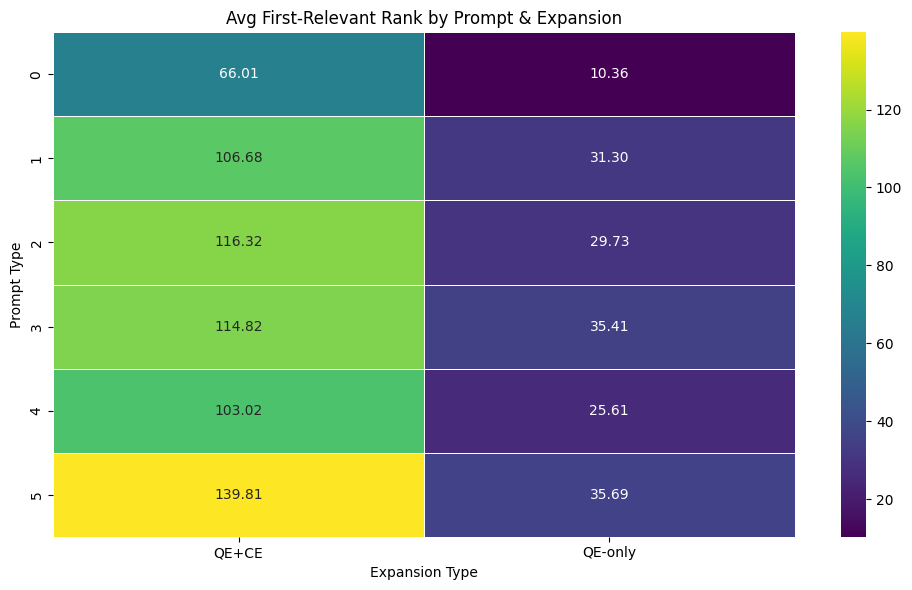

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_metric = per_prompt_df.pivot_table(index='q_prompt', columns='expansion', values='first_relevant_rank', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_metric, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
plt.title("Avg First-Relevant Rank by Prompt & Expansion")
plt.xlabel("Expansion Type")
plt.ylabel("Prompt Type")
plt.tight_layout()
plt.show()


# Max/Min Scores per Expansion

In [26]:

summary = all_df.groupby('expansion')['score'].agg(['min', 'max', 'mean', 'median']).reset_index()
print(summary)

relevant_docs = all_df[all_df['relevance'] == 1]
summary = relevant_docs.groupby('expansion')['score'].agg(['min', 'max', 'mean', 'median']).reset_index()
print(summary)



  expansion       min       max      mean    median
0     QE+CE  0.765634  0.940179  0.819858  0.819045
1   QE-only  0.735766  0.937171  0.794510  0.792782
2  baseline  0.722600  0.913800  0.772179  0.770000
3      none  0.754600  0.937200  0.802626  0.800900
  expansion       min      max      mean    median
0     QE+CE  0.772898  0.92869  0.837756  0.836376
1   QE-only  0.774706  0.92411  0.842899  0.841444
2  baseline  0.769500  0.91380  0.841057  0.841400
3      none  0.809700  0.92410  0.868993  0.869400


/tmp/ipykernel_1787165/3524938591.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='expansion', y='score', data=relevant_docs, inner='quartile', scale='width')


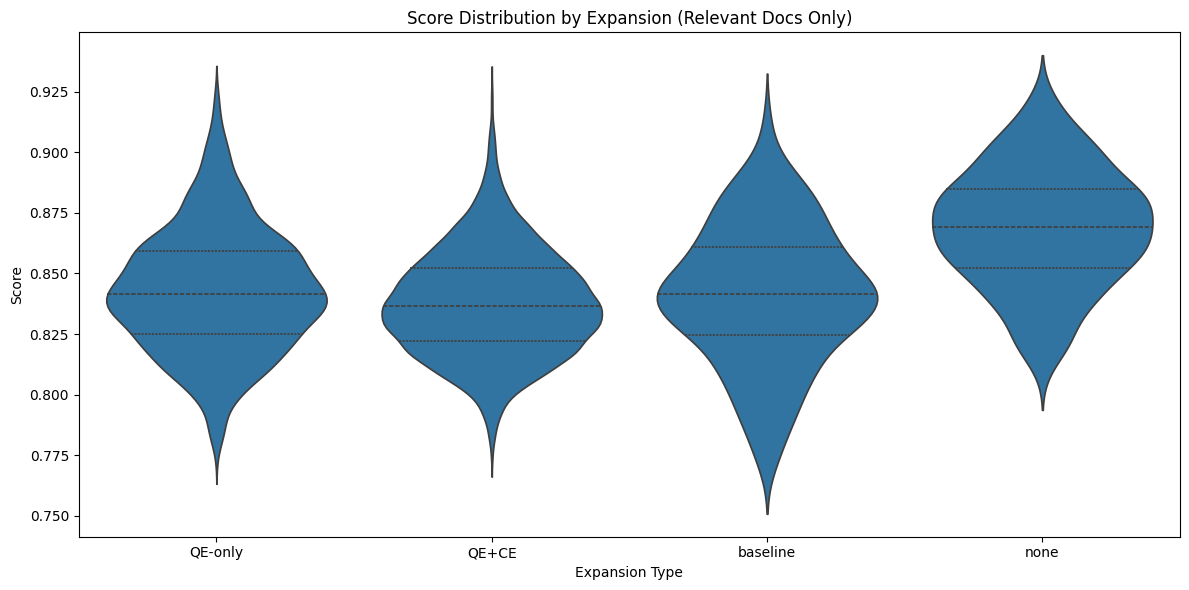

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

relevant_docs = all_df[all_df['relevance'] == 1]

plt.figure(figsize=(12, 6))
sns.violinplot(x='expansion', y='score', data=relevant_docs, inner='quartile', scale='width')
plt.title('Score Distribution by Expansion (Relevant Docs Only)')
plt.ylabel('Score')
plt.xlabel('Expansion Type')
plt.tight_layout()
plt.show()


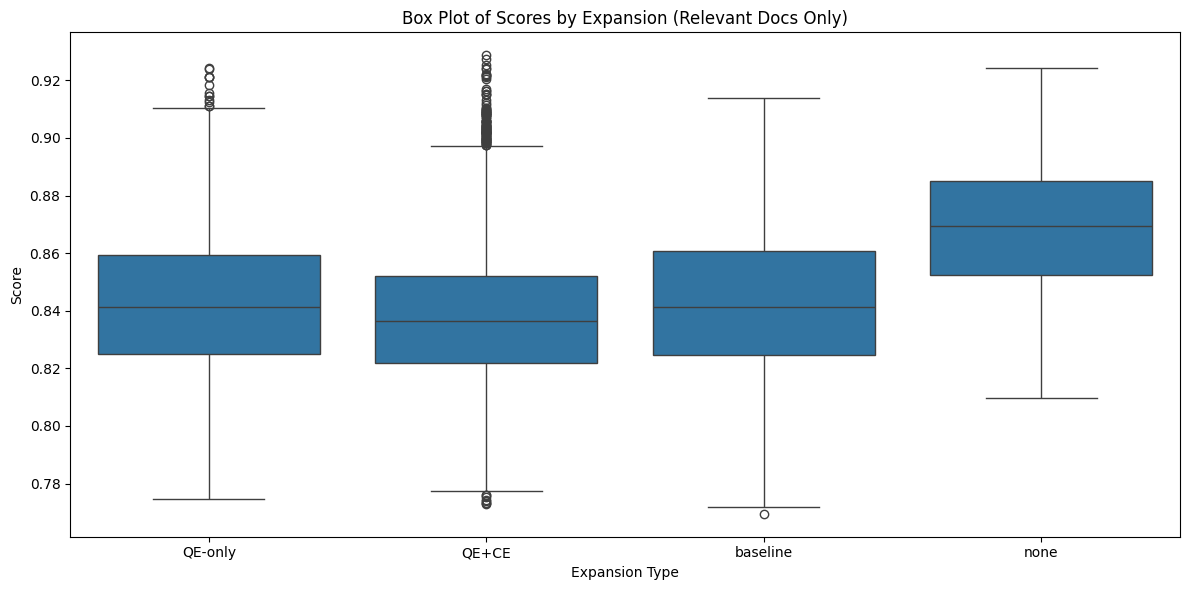

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='expansion', y='score', data=relevant_docs)
plt.title('Box Plot of Scores by Expansion (Relevant Docs Only)')
plt.ylabel('Score')
plt.xlabel('Expansion Type')
plt.tight_layout()
plt.show()


# rank based 

In [29]:
from collections import defaultdict
import pandas as pd

df_sorted = all_df.sort_values(by=['expansion', 'query_base', 'score'], ascending=[True, True, False])

first_relevant_ranks = []

for (expansion, query), group in df_sorted.groupby(['expansion', 'query_base']):
    group = group.reset_index(drop=True)
    group['rank'] = group.index + 1
    relevant_rows = group[group['relevance'] == 1]
    
    if not relevant_rows.empty:
        first_rank = relevant_rows['rank'].iloc[0]
        first_relevant_ranks.append({
            'expansion': expansion,
            'query': query,
            'first_relevant_rank': first_rank,
            'reciprocal_rank': 1 / first_rank
        })


In [30]:
rank_df = pd.DataFrame(first_relevant_ranks)

summary = rank_df.groupby('expansion')['first_relevant_rank'].describe(percentiles=[.25, .5, .75])
mrr = rank_df.groupby('expansion')['reciprocal_rank'].mean().rename("MRR")

summary = summary.join(mrr)
print(summary)


           count        mean         std  min  25%   50%    75%     max  \
expansion                                                                 
QE+CE      497.0  166.269618  467.629187  1.0  6.0  25.0  107.0  5712.0   
QE-only    275.0   17.810909   62.537935  1.0  1.0   3.0   11.0   761.0   
baseline   275.0   19.760000   71.340403  1.0  1.0   2.0    8.0   875.0   
none       275.0   10.345455   26.525444  1.0  1.0   2.0    7.0   243.0   

                MRR  
expansion            
QE+CE      0.180312  
QE-only    0.512048  
baseline   0.525116  
none       0.548407  


In [31]:
rank_df

,expansion,query,first_relevant_rank,reciprocal_rank
0,QE+CE,q20105,1,1.000000
1,QE+CE,q20106,23,0.043478
2,QE+CE,q20107,1412,0.000708
3,QE+CE,q20108,135,0.007407
4,QE+CE,q20109,1,1.000000
...,...,...,...,...
1317,none,q20599,2,0.500000
1318,none,q20600,4,0.250000
1319,none,q20601,4,0.250000
1320,none,q20602,19,0.052632


# Difficulty based 

In [32]:
best_method_ranks = per_prompt_df.groupby('query')['first_relevant_rank'].min().reset_index()
best_method_ranks['difficulty'] = pd.cut(
    best_method_ranks['first_relevant_rank'],
    bins=[0, 50, 150, float('inf')],
    labels=['easy', 'medium', 'hard']
)


In [33]:
per_prompt_df = per_prompt_df.merge(best_method_ranks[['query', 'difficulty']], on='query')
rank_by_difficulty = per_prompt_df.groupby(['difficulty', 'expansion'])['first_relevant_rank'].mean().unstack()
print("Avg First-Relevant Rank by Difficulty and Expansion:")
print(rank_by_difficulty)

Avg First-Relevant Rank by Difficulty and Expansion:
expansion        QE+CE     QE-only
difficulty                        
easy         93.115197   23.943315
medium      314.213483  291.000000
hard        533.933333  506.727273


In [34]:
mrr_by_difficulty = per_prompt_df.groupby(['difficulty', 'expansion'])['reciprocal_rank'].mean().unstack()
print("MRR by Difficulty and Expansion:")
print(mrr_by_difficulty)

MRR by Difficulty and Expansion:
expansion      QE+CE   QE-only
difficulty                    
easy        0.161227  0.420201
medium      0.005771  0.004737
hard        0.002607  0.002480


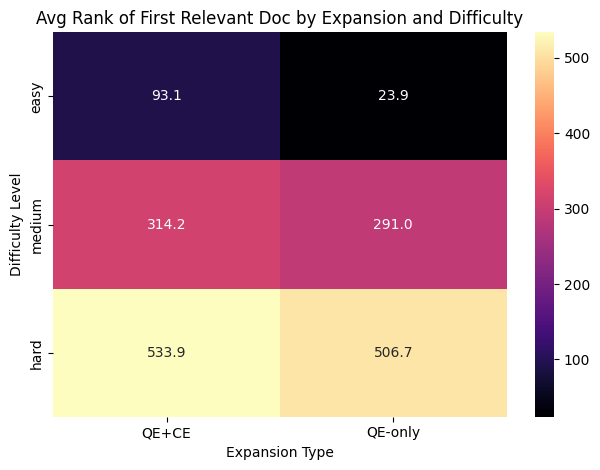

In [35]:
prompt_by_difficulty = per_prompt_df.groupby(['difficulty', 'q_prompt'])['first_relevant_rank'].mean().unstack()
sns.heatmap(rank_by_difficulty, annot=True, cmap="magma", fmt=".1f")
plt.title("Avg Rank of First Relevant Doc by Expansion and Difficulty")
plt.ylabel("Difficulty Level")
plt.xlabel("Expansion Type")
plt.tight_layout()
plt.show()

# Error case

In [36]:
collapsed_all_df = pd.concat([collapsed_expl_df, collapsed_qce_df, collapsed_qe_df, collapsed_baseline_df])
collapsed_all_df

,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion,rank
0,q20105,d20105,0.8757,1,none,1
1,q20105,d20330,0.8618,0,none,2
2,q20105,d6447,0.8576,0,none,3
3,q20105,d20117,0.8501,0,none,4
4,q20105,d4312,0.8482,0,none,5
...,...,...,...,...,...,...
499995,q20604,d20170,0.7494,0,baseline,996
499996,q20604,d14001,0.7494,0,baseline,997
499997,q20604,d2125,0.7494,0,baseline,998
499998,q20604,d15701,0.7494,0,baseline,999


In [37]:
collapsed_all_df[(collapsed_all_df['query_id'] == 'q20105') & (collapsed_all_df['ground_truth_relevance'] == 1)]

,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion,rank
0,q20105,d20105,0.875700,1,none,1
16,q20105,d20105,0.844824,1,QE+CE,17
0,q20105,d20105,0.864300,1,QE-only,1
0,q20105,d20105,0.847400,1,baseline,1


In [38]:
first_relevant_rank = collapsed_all_df[collapsed_all_df['ground_truth_relevance'] == 1]
first_relevant_rank

,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion,rank
0,q20105,d20105,0.8757,1,none,1
1000,q20106,d20106,0.8686,1,none,1
2020,q20107,d20107,0.8345,1,none,21
4000,q20109,d20109,0.8766,1,none,1
6000,q20111,d20111,0.8935,1,none,1
...,...,...,...,...,...,...
494001,q20599,d20599,0.8826,1,baseline,2
495001,q20600,d20600,0.8183,1,baseline,2
496001,q20601,d20601,0.8790,1,baseline,2
497002,q20602,d20602,0.8280,1,baseline,3


In [39]:
first_relevant_rank[first_relevant_rank['query_id'] == 'q20106']

,query_id,retrieved_doc_id,score,ground_truth_relevance,expansion,rank
1000,q20106,d20106,0.868600,1,none,1
1023,q20106,d20106,0.836207,1,QE+CE,24
1002,q20106,d20106,0.857900,1,QE-only,3
1003,q20106,d20106,0.826600,1,baseline,4


In [40]:
avg_rank = (
    first_relevant_rank
    .groupby('expansion')['rank']
    .mean()
    .reset_index(name='avg_first_relevant_rank')
)
print("Average First‐Relevant Rank by Expansion:")
print(avg_rank)

Average First‐Relevant Rank by Expansion:
  expansion  avg_first_relevant_rank
0     QE+CE                94.909091
1   QE-only                16.809237
2  baseline                19.760000
3      none                10.345455


In [41]:
best_per_query = (
    first_relevant_rank
    .loc[first_relevant_rank.groupby('query_id')['rank'].idxmin()]
    [['query_id','expansion','rank']]
    .rename(columns={'expansion':'best_expansion','rank':'best_rank'})
)
print("\nSample of Best Expansion per Query:")
print(best_per_query.head())


Sample of Best Expansion per Query:
     query_id best_expansion  best_rank
0      q20105           none          1
0      q20105        QE-only          1
0      q20105       baseline          1
1000   q20106           none          1
2005   q20107       baseline          6


In [42]:
win_counts = best_per_query['best_expansion'] \
    .value_counts() \
    .reset_index() \
    

In [43]:
win_counts

,best_expansion,count
0,QE-only,346
1,none,166
2,baseline,149
3,QE+CE,26


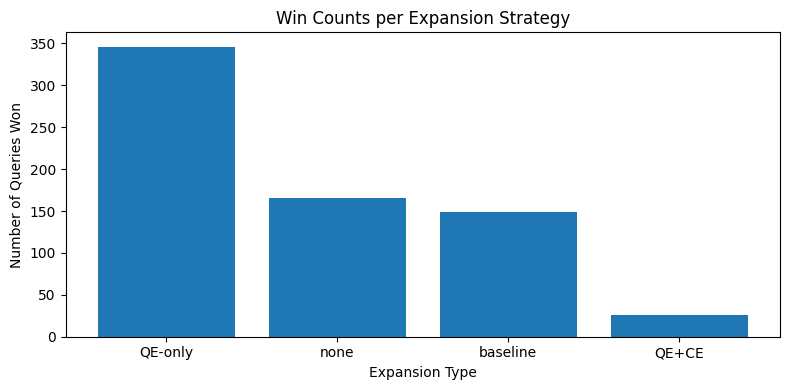

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(win_counts['best_expansion'], win_counts['count'])
plt.title('Win Counts per Expansion Strategy')
plt.xlabel('Expansion Type')
plt.ylabel('Number of Queries Won')
plt.tight_layout()
plt.show()